In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tushare as ts
import tensorflow as tf
from tensorflow.keras import layers

# 获取数据
ts.set_token('b425510f91120626ceacdcd9a36087804c9484b2555dd79beab964b2')
pro=ts.pro_api()
ticker='000002'
Vanke = ts.get_k_data(ticker, '2020-01-01', '2024-10-01')
Vanke.set_index('date', inplace=True)
Vanke.index = pd.to_datetime(Vanke.index)
data = Vanke

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Flatten, Dense, Dropout, Multiply, Lambda
from tensorflow.keras.models import Model

# 计算RSI指标
def calculate_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 添加RSI列
data['RSI'] = calculate_rsi(data, window=14)
# 删除RSI为0和NaN的行
data = data[(data['RSI'] != 0) & (~data['RSI'].isna())]
data

,open,close,high,low,volume,code,RSI
date,,,,,,,
2020-01-07,27.70,27.85,28.02,27.44,577933.0,000002,19.230769
2020-01-08,27.39,27.77,27.86,27.14,529996.0,000002,18.115942
2020-01-09,28.24,28.29,28.57,27.94,783734.0,000002,40.526316
2020-01-10,28.09,27.55,28.31,27.44,557443.0,000002,29.166667
2020-01-13,27.49,27.77,27.87,27.35,620749.0,000002,34.615385
...,...,...,...,...,...,...,...
2024-09-24,7.07,7.12,7.17,6.81,3244215.0,000002,75.000000
2024-09-25,7.14,7.31,7.68,7.11,3935250.0,000002,76.510067
2024-09-26,7.22,8.04,8.04,7.22,5278410.0,000002,86.574074


In [3]:
# 选择所需的特征
features = ['open', 'close', 'high', 'low', 'RSI']

# 数据归一化
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 创建时间序列输入
def create_sequences(data, feature_columns, sequence_length=8):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[feature_columns].iloc[i:i+sequence_length].values
        label = data[feature_columns].iloc[i+sequence_length].values
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# 使用前8天的数据预测第9天的open, close, high, low, RSI
sequence_length = 8
X, y = create_sequences(data, features, sequence_length)

# 分割数据集（80% 训练集, 20% 测试集）
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

C:\Users\jc\AppData\Local\Temp\ipykernel_17668\4121442891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = scaler.fit_transform(data[features])


In [4]:
# 定义 TemporalBlock 类
class TemporalBlock(layers.Layer):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = layers.Conv1D(n_outputs, kernel_size, strides=stride, dilation_rate=dilation, padding=padding)
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv1D(n_outputs, kernel_size, strides=stride, dilation_rate=dilation, padding=padding)
        self.residual = layers.Conv1D(n_outputs, kernel_size=1)
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs):
        res = self.residual(inputs)
        x = self.relu(self.conv1(inputs))
        x = self.conv2(x)
        x = self.dropout(x)
        x += res
        return x
    
class TCNModel(tf.keras.Model):
    def __init__(self, input_shape, num_channels=[64, 64, 64], kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()

        self.input_layer = layers.InputLayer(input_shape=input_shape)
        self.blocks = []

        # 构建 Temporal Blocks
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_shape[1] if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            self.blocks.append(TemporalBlock(n_inputs=in_channels, n_outputs=out_channels, kernel_size=kernel_size,
                                             stride=1, dilation=dilation_size, padding='causal', dropout=dropout))

        # 定义 Flatten 和 Dense 层
        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(dropout)
        self.dense = layers.Dense(len(features), activation='linear')  # 输出与特征数一致

    def call(self, inputs):
        x = inputs
        for block in self.blocks:
            x = block(x)
        x = self.flatten(x)
        x = self.dropout(x)
        output = self.dense(x)
        return output

In [8]:
# 模型定义和编译
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
model = TCNModel(input_shape)

# 编译模型
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=64)

# 模型预测
y_pred = model.predict(X_test)


Epoch 1/100


D:\anaconda\conda\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.2734 - mae: 0.3684
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0154 - mae: 0.0930
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - mae: 0.0601
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - mae: 0.0482
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - mae: 0.0422
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - mae: 0.0383
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - mae: 0.0364
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0374
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - mae: 0.0365
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - mae: 0.0346
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - mae: 0.0330
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - mae: 0.0313
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - mae: 0.0249
Epoch 72/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - mae: 0.0241
Epoch 73/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - mae: 0.0239
Epoch 74/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - mae: 0.0242
Epoch 75/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - mae: 0.0285
Epoch 76/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - mae: 0.0234
Epoch 77/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - mae: 0.0224
Epoch 78/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - mae: 0.0225
Epoch 79/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - mae: 0.0218
Epoch 80/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - mae: 0.0259
Epoch 81/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - mae: 0.0221
Epoch 82/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - mae: 0.0230
Epoch 83/100
15/15 ━━━━━━━━━━

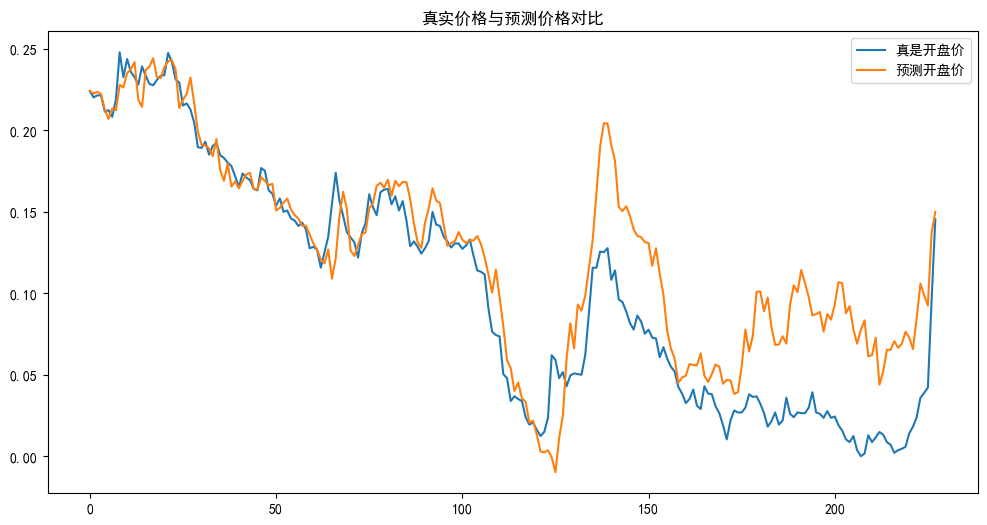

In [9]:
# 可视化预测结果
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='真是开盘价')
plt.plot(y_pred[:, 0], label='预测开盘价')
plt.title('真实价格与预测价格对比')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 计算MAE、RMSE、MAPE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 计算绝对误差和误差分布
absolute_errors = np.abs(y_test - y_pred)
mean_absolute_error_by_feature = np.mean(absolute_errors, axis=0)

# 打印每个特征的平均绝对误差
features = ['Open', 'Close', 'High', 'Low','RSI']  # 对应的特征列
for i, feature in enumerate(features):
    print(f"Mean Absolute Error for {feature}: {mean_absolute_error_by_feature[i]:.4f}")


Mean Absolute Error (MAE): 0.0395
Root Mean Squared Error (RMSE): 0.0566
Mean Absolute Error for Open: 0.0269
Mean Absolute Error for Close: 0.0310
Mean Absolute Error for High: 0.0309
Mean Absolute Error for Low: 0.0394
Mean Absolute Error for RSI: 0.0693


C:\Users\jc\AppData\Local\Temp\ipykernel_17668\1536759930.py:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


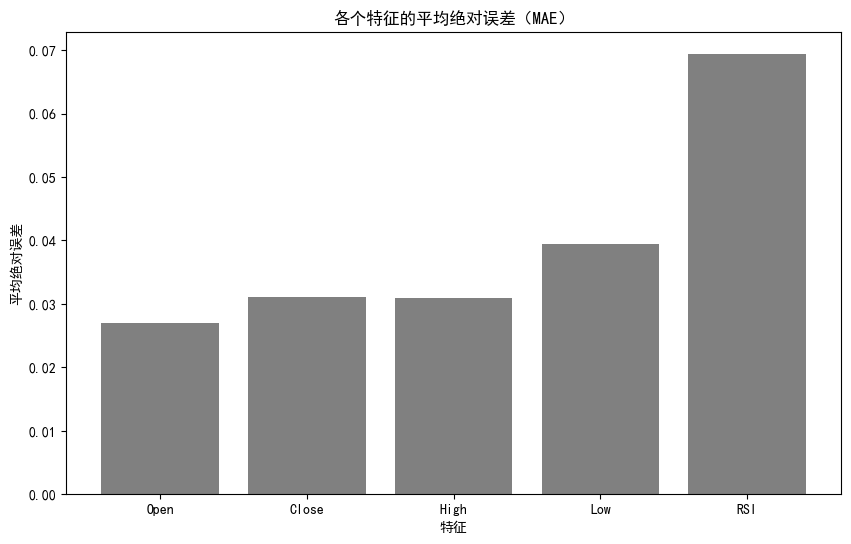

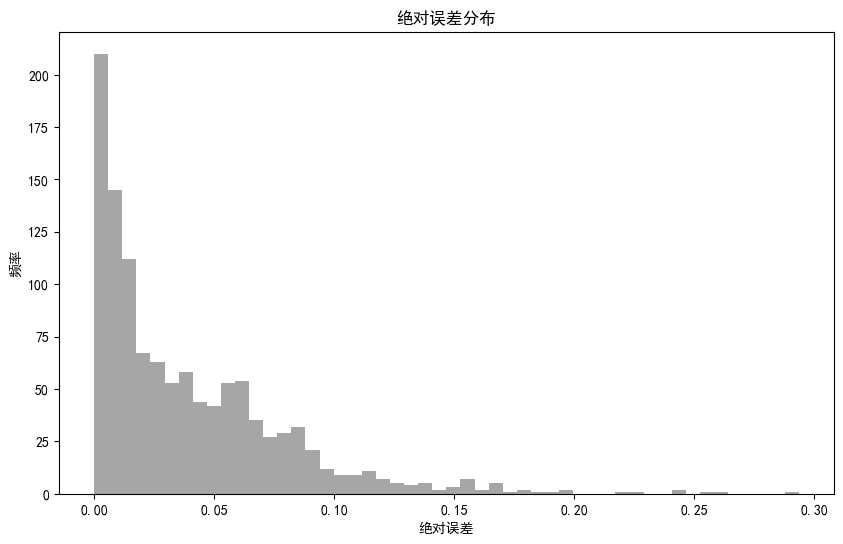

In [12]:
# 2. 绘制每个特征的平均绝对误差条形图
plt.figure(figsize=(10, 6))
plt.bar(features, mean_absolute_error_by_feature, color='grey')
plt.title('各个特征的平均绝对误差（MAE）')
plt.xlabel('特征')
plt.ylabel('平均绝对误差')
plt.show()

# 3. 绘制误差的分布图（直方图）
plt.figure(figsize=(10, 6))
plt.hist(absolute_errors.flatten(), bins=50, color='grey', alpha=0.7)
plt.title('绝对误差分布')
plt.xlabel('绝对误差')
plt.ylabel('频率')
plt.show()